#**Classificação: melhorando o desempenho com XGBoost**

##**1 - Conhecendo os dados**

### **Importando os dados**

In [53]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb

SEED=101

In [54]:
url = 'https://raw.githubusercontent.com/alura-cursos/classificacao_xgboost/main/Dados/doenca_cardiaca.csv'
df = pd.read_csv(url)
df.head()

### **Explorando os dados**

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Idade                    270 non-null    int64  
 1   Sexo                     270 non-null    int64  
 2   Tipo dor                 270 non-null    int64  
 3   Pressao arterial         270 non-null    int64  
 4   Colesterol               270 non-null    int64  
 5   Glicemia jejum >120      270 non-null    int64  
 6   Resultados ECG           270 non-null    int64  
 7   Frequencia cardiaca max  270 non-null    int64  
 8   Dor exercicio            270 non-null    int64  
 9   Depressao ST             270 non-null    float64
 10  Inclinacao ST            270 non-null    int64  
 11  Numero vasos fluro       270 non-null    int64  
 12  Teste cintilografia      270 non-null    int64  
 13  Doenca cardiaca          270 non-null    object 
dtypes: float64(1), int64(12), 

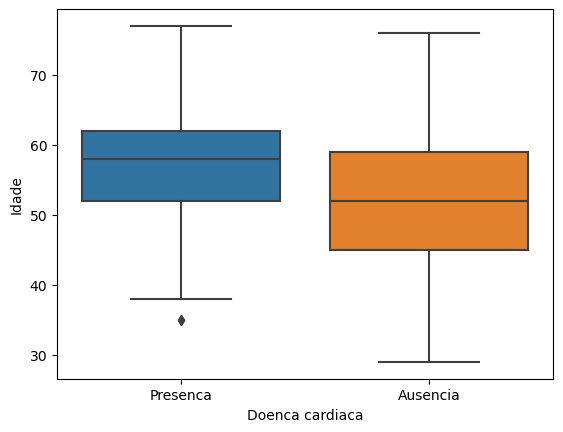

In [58]:
sns.boxplot(x='Doenca cardiaca', y='Idade', data=df);

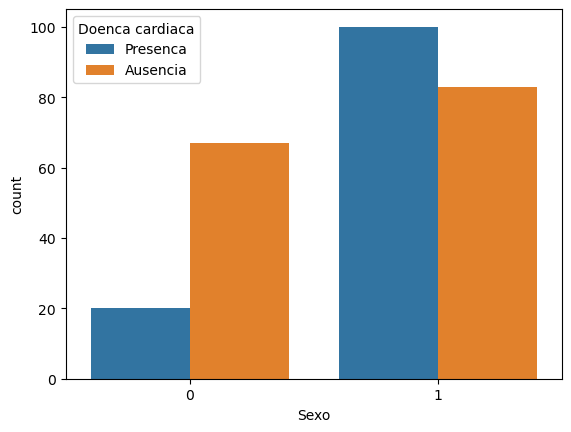

In [59]:
sns.countplot(x='Sexo', hue='Doenca cardiaca', data=df);

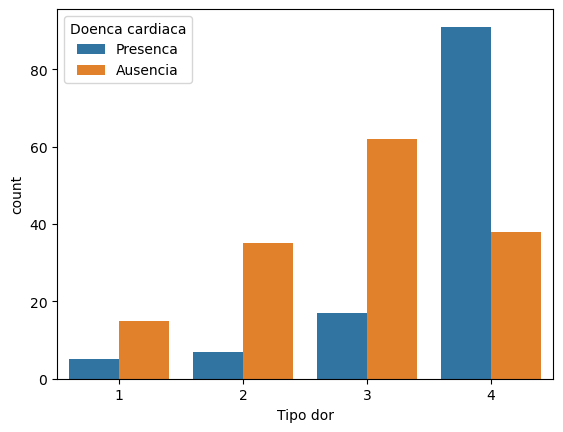

In [60]:
sns.countplot(x='Tipo dor', hue='Doenca cardiaca', data=df);

In [61]:
df['Doenca cardiaca'].value_counts()

Doenca cardiaca
Ausencia    150
Presenca    120
Name: count, dtype: int64

In [62]:
df['Doenca cardiaca'] = df['Doenca cardiaca'].map({'Presenca': 1, 'Ausencia': 0})

In [63]:
df.head()

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia,Doenca cardiaca
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


##**2 - Iniciando a classificação**

### **Separando os dados**

In [64]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [65]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

### **Classificando com Decision Tree**

In [66]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_treino, y_treino)
preds = dt.predict(X_teste)
acuracia = accuracy_score(y_teste, preds)
print(f'Acuracia: {acuracia:.2f}')

Acuracia: 0.76


### **Analisando as métricas do Decision Tree**

In [67]:
report = classification_report(y_teste, preds)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.73      0.77        30
           1       0.70      0.79      0.75        24

    accuracy                           0.76        54
   macro avg       0.76      0.76      0.76        54
weighted avg       0.77      0.76      0.76        54



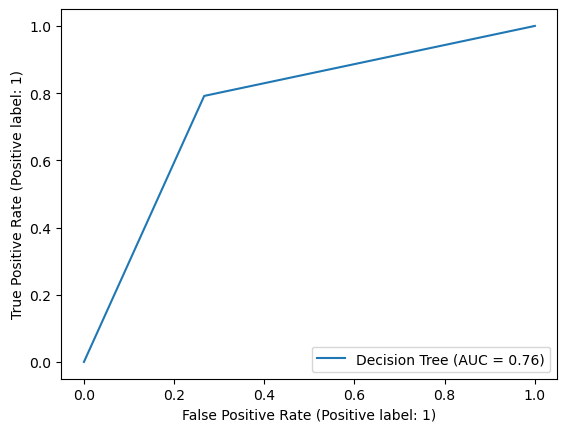

In [68]:
RocCurveDisplay.from_predictions(y_teste, preds, name='Decision Tree');

### **Classificando com XGBoost**

In [70]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic')
xg_cl.fit(X_treino, y_treino)
preds = xg_cl.predict(X_teste)

acuracia = accuracy_score(y_teste, preds)
print(f'Acuracia: {acuracia:.2f}')

Acuracia: 0.81


### **Analisando as métricas do XGBoost**

In [71]:
report = classification_report(y_teste, preds)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.77      0.83      0.80        24

    accuracy                           0.81        54
   macro avg       0.81      0.82      0.81        54
weighted avg       0.82      0.81      0.82        54



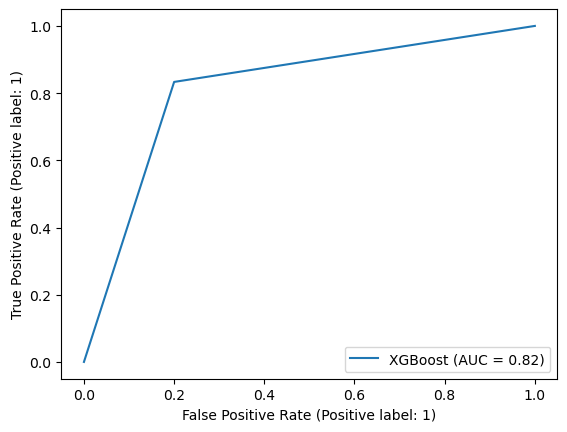

In [72]:
RocCurveDisplay.from_predictions(y_teste, preds, name='XGBoost');

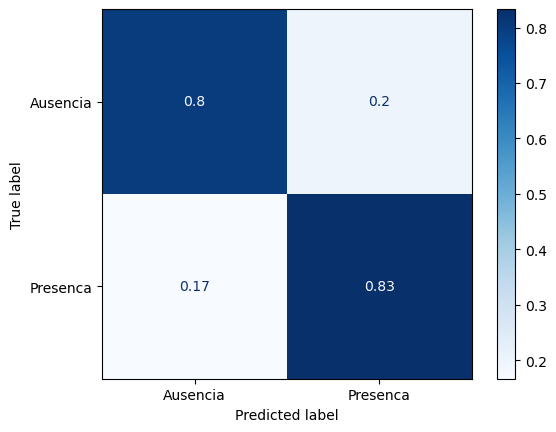

In [73]:
ConfusionMatrixDisplay.from_estimator(xg_cl, X_teste, y_teste, display_labels=['Ausencia', 'Presenca'],
                                      normalize='true', cmap='Blues');

##**3 - Realizando a validação cruzada**

### **Aplicando a validação cruzada**

In [74]:
dmatrix = xgb.DMatrix(data=X, label=y)

In [75]:
params = {'objective': 'binary:logistic'}

cv_resultados = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=5, metrics='error',as_pandas=True, seed=123)

print(cv_resultados)
acuracia = 1 - cv_resultados['test-error-mean'].iloc[-1]
print(f'Acuracia: {acuracia}')

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.138889         0.023570         0.288889        0.055184
1          0.081481         0.010476         0.262963        0.010476
2          0.068519         0.013858         0.248148        0.037771
3          0.050000         0.007857         0.229630        0.010476
4          0.046296         0.010476         0.222222        0.018144
Acuracia: 0.7777777777777778


### **Explorando a técnica de Early Stopping**

In [76]:
params = {'objective': 'binary:logistic'}

cv_resultados = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=50, metrics='error',as_pandas=True, seed=123)

print(cv_resultados)
acuracia = 1 - cv_resultados['test-error-mean'].iloc[-1]
print(f'Acuracia: {acuracia}')

    train-error-mean  train-error-std  test-error-mean  test-error-std
0           0.138889         0.023570         0.288889        0.055184
1           0.081481         0.010476         0.262963        0.010476
2           0.068519         0.013858         0.248148        0.037771
3           0.050000         0.007857         0.229630        0.010476
4           0.046296         0.010476         0.222222        0.018144
5           0.033333         0.013608         0.214815        0.013858
6           0.024074         0.006929         0.207407        0.013858
7           0.022222         0.007857         0.225926        0.010476
8           0.020370         0.009443         0.218519        0.005238
9           0.016667         0.004536         0.225926        0.013858
10          0.014815         0.005238         0.218519        0.010476
11          0.012963         0.006929         0.218519        0.013858
12          0.012963         0.006929         0.218519        0.010476
13    

In [77]:
params = {'objective': 'binary:logistic'}

cv_resultados = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=100, early_stopping_rounds=5,metrics='error', as_pandas=True, seed=123)

print(cv_resultados)
acuracia = 1 - cv_resultados['test-error-mean'].iloc[-1]
print(f'Acuracia: {acuracia}')

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.138889         0.023570         0.288889        0.055184
1          0.081481         0.010476         0.262963        0.010476
2          0.068519         0.013858         0.248148        0.037771
3          0.050000         0.007857         0.229630        0.010476
4          0.046296         0.010476         0.222222        0.018144
5          0.033333         0.013608         0.214815        0.013858
6          0.024074         0.006929         0.207407        0.013858
Acuracia: 0.7925925925925926


##**4 - Ajustando hiperparâmetros do XGBoost**

### **Conhecendo os principais hiperparâmetros**

In [78]:
params = {'objective': 'binary:logistic', 'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5}

cv_resultados = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=100, early_stopping_rounds=5,metrics='error', as_pandas=True, seed=123)

print(cv_resultados)
acuracia = 1 - cv_resultados['test-error-mean'].iloc[-1]
print(f'Acuracia: {acuracia}')

    train-error-mean  train-error-std  test-error-mean  test-error-std
0           0.307407         0.061586         0.359259        0.135881
1           0.262963         0.093661         0.344444        0.148518
2           0.224074         0.057794         0.292593        0.109369
3           0.177778         0.065420         0.318519        0.082319
4           0.166667         0.040318         0.259259        0.063721
5           0.153704         0.032815         0.255556        0.047140
6           0.133333         0.024003         0.244444        0.039545
7           0.125926         0.013095         0.240741        0.026189
8           0.107407         0.013858         0.233333        0.024003
9           0.105556         0.012001         0.229630        0.020951
10          0.101852         0.013095         0.229630        0.005238
11          0.096296         0.009443         0.218519        0.020951
12          0.092593         0.011416         0.211111        0.015713
13    

### **Aplicando o Random Search**

In [79]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [0, 2, 4, 6, 10],
    'colsample_bytree': [0.1, 0.5, 1],
    'n_estimators': [10, 25, 50]
}

modelo_xgb = xgb.XGBClassifier()

random_search_cv = RandomizedSearchCV(estimator=modelo_xgb, param_distributions=params, n_iter=5, cv=4, scoring='accuracy',verbose=1)

random_search_cv.fit(X,y)

print('Melhores parametros encontrados: ', random_search_cv.best_params_)
print('Acuracia:', random_search_cv.best_score_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Melhores parametros encontrados:  {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Acuracia: 0.8294556628621599


### **Aplicando o Grid Search**

In [80]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [0, 2, 4, 6, 10],
    'colsample_bytree': [0.1, 0.5, 1],
    'n_estimators': [10, 25, 50]
}

modelo_xgb = xgb.XGBClassifier()

grid_search_cv = GridSearchCV(estimator=modelo_xgb, param_grid=params, cv=4, scoring='accuracy', verbose=1)

grid_search_cv.fit(X,y)

print('Melhores parametros encontrados: ', grid_search_cv.best_params_)
print('Acuracia:', grid_search_cv.best_score_)

Fitting 4 folds for each of 135 candidates, totalling 540 fits


Melhores parametros encontrados:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
Acuracia: 0.8409240561896401


### **Analisando as métricas após ajuste dos hiperparâmetros**

In [81]:
xg_cl_ajustado = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=1,
                                  learning_rate=0.1, max_depth=2, n_estimators=50)

xg_cl_ajustado.fit(X_treino, y_treino)

preds = xg_cl_ajustado.predict(X_teste)

acuracia = accuracy_score(y_teste, preds)
print(f'Acuracia: {acuracia:.2f}')

Acuracia: 0.85


In [82]:
report = classification_report(y_teste, preds)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.81      0.88      0.84        24

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



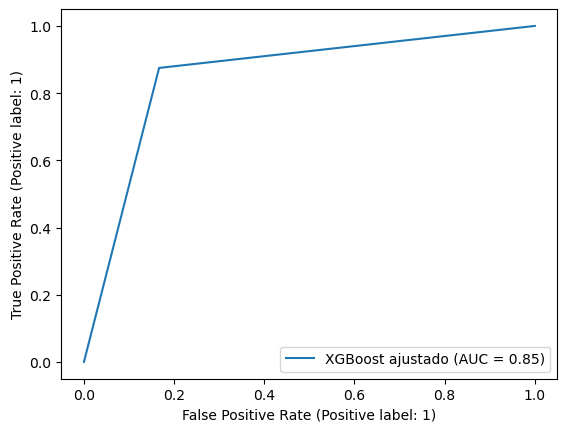

In [83]:
RocCurveDisplay.from_predictions(y_teste, preds, name='XGBoost ajustado');

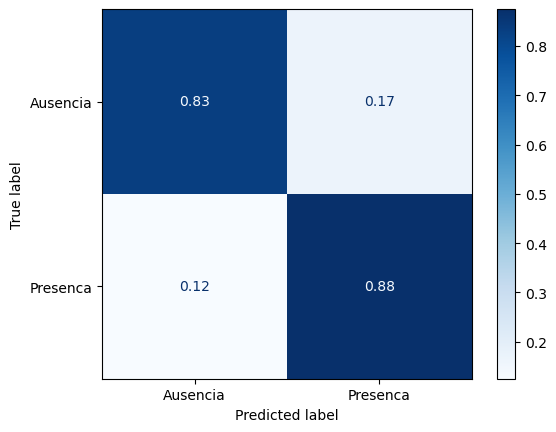

In [84]:
ConfusionMatrixDisplay.from_estimator(xg_cl_ajustado, X_teste, y_teste, display_labels=['Ausencia', 'Presenca'],
                                      normalize='true', cmap='Blues')

##**5 - Utilizando o XGBoost em pipelines**

### **Incorporando XGBoost em pipelines**

In [85]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('xgboost', xgb.XGBClassifier())])

xgb_param_grid = {
    'xgboost__learning_rate': [0.1, 0.2, 0.3],
    'xgboost__max_depth': [0, 2, 4, 6, 10],
    'xgboost__colsample_bytree': [0.1, 0.5, 1],
    'xgboost__n_estimators': [10, 25, 50]
}

grid_search_cv = GridSearchCV(estimator=pipeline, param_grid=xgb_param_grid,
                              scoring='accuracy', cv=4, verbose=1)

grid_search_cv.fit(X, y)

print('Acuracia:', grid_search_cv.best_score_)
print('Melhor estimador:', grid_search_cv.best_estimator_)

Fitting 4 folds for each of 135 candidates, totalling 540 fits
Acuracia: 0.8409240561896401
Melhor estimador: Pipeline(steps=[('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                     

In [86]:
import joblib

joblib.dump(grid_search_cv, 'modelo_pipeline.pkl')

['modelo_pipeline.pkl']

### **Utilizando o modelo com dados novos**

In [87]:
modelo = joblib.load('modelo_pipeline.pkl')

In [88]:
url = 'https://raw.githubusercontent.com/alura-cursos/classificacao_xgboost/main/Dados/pacientes_novos.csv'

In [89]:
novos_pacientes = pd.read_csv(url)

In [90]:
novos_pacientes

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia
0,41,1,4,110,172,0,2,158,0,0.0,1,0,7
1,45,0,4,102,265,0,2,122,0,0.6,2,0,3
2,50,1,3,130,246,1,2,173,0,0.0,1,3,3
3,52,0,4,100,248,0,2,122,0,1.0,2,0,3
4,54,0,3,110,214,0,0,158,0,1.6,2,0,3
5,70,0,1,140,239,0,0,151,0,1.8,1,2,3
6,42,0,4,132,341,1,2,136,1,3.0,2,0,7
7,34,0,1,150,283,1,2,162,0,1.0,1,0,3
8,52,1,1,118,186,0,2,190,0,0.0,2,0,6
9,35,1,4,112,245,0,0,150,0,1.0,2,2,3


In [91]:
previsoes = modelo.predict(novos_pacientes)

In [92]:
previsoes

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [93]:
probabilidades = modelo.predict_proba(novos_pacientes)

In [94]:
probabilidades

array([[0.47394192, 0.5260581 ],
       [0.8558974 , 0.14410257],
       [0.73324203, 0.26675797],
       [0.7878467 , 0.21215333],
       [0.95727295, 0.04272704],
       [0.8929907 , 0.10700932],
       [0.09207231, 0.9079277 ],
       [0.8851794 , 0.11482063],
       [0.9037258 , 0.0962742 ],
       [0.20894748, 0.7910525 ]], dtype=float32)

In [95]:
df_novos_pacientes = pd.DataFrame(novos_pacientes)

df_novos_pacientes['previsoes'] = previsoes

df_novos_pacientes

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia,previsoes
0,41,1,4,110,172,0,2,158,0,0.0,1,0,7,1
1,45,0,4,102,265,0,2,122,0,0.6,2,0,3,0
2,50,1,3,130,246,1,2,173,0,0.0,1,3,3,0
3,52,0,4,100,248,0,2,122,0,1.0,2,0,3,0
4,54,0,3,110,214,0,0,158,0,1.6,2,0,3,0
5,70,0,1,140,239,0,0,151,0,1.8,1,2,3,0
6,42,0,4,132,341,1,2,136,1,3.0,2,0,7,1
7,34,0,1,150,283,1,2,162,0,1.0,1,0,3,0
8,52,1,1,118,186,0,2,190,0,0.0,2,0,6,0
9,35,1,4,112,245,0,0,150,0,1.0,2,2,3,1
